# Text classification with Transformer

* Taken from Apoorv Nandan's work on the awesome [Super Dooper NLP repo](https://notebooks.quantumstat.com/#/)
* Transformers are parallelisable networks - LSTMs are sequential
* Transformers are faster and bigger than LSTMS (billions of parameters) - they're v expensive to train - (millions of dollars)
* They are better than the competition

---

# Theory
[The paper](https://arxiv.org/pdf/1706.03762.pdf)

![](Transformer.png)

### The cool bit is Attention! Which Ill explain briefly
* Check out [jalammer's blog](https://jalammar.github.io/illustrated-transformer/) for more info

---

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

if not tf.__version__ == '2.4.1':
    raise Exception('you might have to upgrade your tensorflow version!')

## Implement a Transformer block as a layer
* We use layer normalization not batch normalization here
* In batch normalization, input values of the same neuron for all the data in the mini-batch are normalized. Whereas in layer normalization, input values for all neurons in the same layer are normalized for each data sample

![](normalization.png)

[source](https://machinelearningknowledge.ai/keras-normalization-layers-explained-for-beginners-batch-normalization-vs-layer-normalization/#:~:text=Batch%20Normalization%20vs%20Layer%20Normalization,-Before%20wrapping%20up&text=In%20batch%20normalization%2C%20input%20values,normalized%20for%20each%20data%20sample.)

In [24]:
#override a Keras layer to provide Transformer functionality
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # multi-head attention 
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # passed into a feed forward network - one hidden layer, one output layer which generates the embeddings
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        #pass input through attention
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        #then to a ffn
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


## Implement embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).

In [25]:
#Override a Keras layer to provide Embedding functionality
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        # word embedding input
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # positional embedding input
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # creates a tensor which has the shape of the input tensor - like np.ndarray
        maxlen = tf.shape(x)[-1]
        # creates a 1-d array, with start=start, limit=stop, delta=step 
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # passes this through embedding layer
        positions = self.pos_emb(positions)
        # passes x through embedding layer
        x = self.token_emb(x)
        return x + positions


## Download and prepare dataset

In [4]:
NUM_WORDS=20000
INDEX_FROM=3 
(X_train,y_train),(X_test_x,y_test) = keras.datasets.imdb.load_data(num_words=NUM_WORDS, index_from=INDEX_FROM)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/tom_g/opt/anaconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/tom_g/opt/anaconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprec

In [19]:
(X_train,y_train),(X_test,y_test) = keras.datasets.imdb.load_data(num_words=NUM_WORDS, index_from=INDEX_FROM)

NUM_WORDS=20000
INDEX_FROM=3   # word index offset - the first 4 chars are reserved, see below

#get text equivalent of tokens
word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
word_to_id["<UNUSED>"] = 3

id_to_word = {value:key for key,value in word_to_id.items()}

In [7]:
def visualise_sentence(x):
    """Print string equivalent of the tokens"""
    print(' '.join([id_to_word[id] for id in x if id >0]))

In [11]:
import matplotlib.pyplot as plt

(array([1.7598e+04, 5.3690e+03, 1.4070e+03, 5.1700e+02, 9.4000e+01,
        7.0000e+00, 5.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  11. ,  259.3,  507.6,  755.9, 1004.2, 1252.5, 1500.8, 1749.1,
        1997.4, 2245.7, 2494. ]),
 <BarContainer object of 10 artists>)

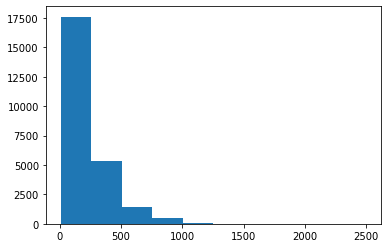

In [13]:
plt.hist([len(x) for x in X_train])

In [8]:
visualise_sentence(X_train[0])

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be p

In [20]:
maxlen = 200  # Only consider the first 200 words of each movie review
print(len(X_train), "Training sequences")
print(len(X_test), "Validation sequences")
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

25000 Training sequences
25000 Validation sequences


## Create classifier model using transformer layer

Transformer layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps to classify text.

In [27]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
vocab_size=20000

model = keras.models.Sequential()
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
model.add(embedding_layer)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
model.add(transformer_block)
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2, activation="softmax"))

## Train and Evaluate

In [ ]:
### Overfitting is a serious problem in NLP
* The metric that models are scored on often is BLEU score, which a general of language tasks

In [29]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    X_train, y_train, batch_size=32, epochs=2, validation_split=0.2
)

Epoch 1/2
625/625 [==============================] - 48s 76ms/step - loss: 0.5305 - accuracy: 0.7029 - val_loss: 0.3057 - val_accuracy: 0.8774
Epoch 2/2
625/625 [==============================] - 52s 84ms/step - loss: 0.1966 - accuracy: 0.9274 - val_loss: 0.3541 - val_accuracy: 0.8564


---

## Test on some unseen data

In [31]:
model.evaluate(X_test,y_test)

782/782 [==============================] - 23s 29ms/step - loss: 0.3714 - accuracy: 0.8470


[0.37143874168395996, 0.8469600081443787]

In [32]:
import numpy as np

In [39]:
random_text = X_test[np.random.randint(len(X_test))]
result = model.predict(random_text).mean(axis=0)
print('Original text is:\n')
print(visualise_sentence(random_text))
print()
print('The models evaluation of sentiment is: \n')
print('Positive: ' + str(round(result[1],2)))
print('Negative: ' + str(round(result[0],2)))

Original text is:

<START> <UNK> of white and various shapes a beautiful nude random images that is what this little experimental short film is br br it's kind of interesting to think how in the early days of film such images could be transferred onto film but despite my love of a lot of surreal images and films and a fascination with the bizarre this film just didn't do it for me br br i'm not sorry i watched it but if there is any underlying meaning in it i don't get it visually it is not that outstanding in my humble opinion as an example of i suppose it would fit in quite well since it seems to reject any semblance of logic or reason though i would have preferred that it do it in a more visually interesting way br br but to each his own
None

The models evaluation of sentiment is: 

Positive: 0.71
Negative: 0.29


---

# BONUS - Use [hugging face](https://huggingface.co/), #1 API for pre-trained Transformers

# BONUS - Use Spacy who also have transformers in their python package

---